# Interconnect

    Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes, ya que esto implica pérdida de ingresos para la empresa.

- Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales para mantener a su clientela.
- Para ello el equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

Para esta tarea se creará un modelo con el fin de predecir si un cliente cancelará sus servicios o no, por lo que tenemos un problema de clasificación supervisada (es una predicción binaria).

## 1 Carga de datos

### 1.1 Importación de bibliotecas y lectura de csv

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import OneHotEncoder
import sklearn; print(sklearn.__version__)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import DistanceMetric
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE

1.6.0


In [108]:
# Carga los archivos de datos en diferentes DataFrames

contract = pd.read_csv('contract.csv')

internet = pd.read_csv('internet.csv')

personal = pd.read_csv('personal.csv')

phone = pd.read_csv('phone.csv')

### 1.2 Esctructura de los datos

#### 1.2.1 Contract - información acerca del contrato

In [109]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [110]:
contract.sample(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6295,7033-CLAMM,2016-02-01,No,Two year,No,Bank transfer (automatic),20.20,1027.25
3983,1334-FJSVR,2019-10-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,24.25,24.25
2030,3090-LETTY,2019-12-01,No,Month-to-month,No,Bank transfer (automatic),60.95,134.6


In [111]:
contract.duplicated().sum()

0

In [112]:
contract.nunique()

customerID          7043
BeginDate             77
EndDate                5
Type                   3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
dtype: int64

In [113]:
contract['Type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

El dataframe **contract** contiene 8 columnas, con 7043 filas y no presenta valores nulos, ni duplicados.

Sus columnas tienen tipos de dato object, a excepción de MonthlyCharges que tiene tipo de dato float.

Sus columnas son:
- custumerID: código único asignado a cada cliente.
- BeginDate: fecha de inicio del contrato.
- EndDate: contiene dos tipos de datos, la fecha de cancelación del contrato o bien si el contrato está vigente presenta el string como 'No'.
- Type: tipo de contrato (mes a mes, un año y dos años).
- PaperlessBilling: si se realizó o no factura electrónica.
- PaymentMethod: método de pago.
- MonthlyCharges: cargos mensuales.
- TotalyCharges: cargos totales.

### 1.2.2 Internet - información sobre los servicios de Internet

In [114]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [115]:
internet.sample(3)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
708,5170-PTRKA,DSL,Yes,No,No,Yes,No,No
5486,2274-XUATA,DSL,Yes,Yes,Yes,Yes,Yes,Yes
4724,7325-ENZFI,DSL,Yes,Yes,No,Yes,No,No


In [116]:
internet.duplicated().sum()

0

In [117]:
internet.nunique()

customerID          5517
InternetService        2
OnlineSecurity         2
OnlineBackup           2
DeviceProtection       2
TechSupport            2
StreamingTV            2
StreamingMovies        2
dtype: int64

El dataframe **internet** contiene 8 columnas, con 5517 filas y no presenta valores nulos, ni duplicados.

Sus columnas tienen tipos de dato object.

Sus columnas son:
- custumerID: código único asignado a cada cliente.
- InternetService: servicios de internet (DSL-línea de abonado digital o a través de un cable de fibra óptica), dato -> SI O NO.
- OnlineSecurity: seguridad en Internet (bloqueador de sitios web maliciosos), dato -> SI O NO.
- OnlineBackup: almacenamiento de archivos en la nube y backup de datos, dato SI O NO.
- DeviceProtection: seguridad en Internet (software antivirus), dato SI O NO.
- TechSupport: línea de soporte técnico, dato SI O NO.
- StreamingTV: streaming de TV, dato SI O NO.
- StreamingMovies: directorio de películas, dato SI O NO.

### 1.2.3 Phone - información sobre los servicios telefónicos

In [118]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [119]:
phone.sample(3)

,customerID,MultipleLines
5294,9846-GKXAS,No
1444,5939-SXWHM,Yes
5244,4291-TPNFG,Yes


In [120]:
phone.duplicated().sum()

0

El dataframe **phone** contiene 2 columnas, con 6361 filas y no presenta valores nulos, ni duplicados.

Sus columnas tienen tipos de dato object.

Sus columnas son:
- custumerID: código único asignado a cada cliente.
- MultipleLines: 'Si' en caso de que el telefóno se pueda conectar a varias líneas de manera simultánea.

### 1.2.4 Personal - datos personales del cliente

In [121]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [122]:
personal.sample(3)

,customerID,gender,SeniorCitizen,Partner,Dependents
2903,0953-LGOVU,Male,0,Yes,Yes
1144,0841-NULXI,Male,0,No,No
2674,1855-CFULU,Female,1,No,No


In [123]:
personal.duplicated().sum()

0

El dataframe **personal** contiene 5 columnas, con 7043 filas y no presenta valores nulos, ni duplicados.

Sus columnas tienen tipos de dato object, a excepción de SeniorCitizen que es de tipo int.

Sus columnas son:
- custumerID: código único asignado a cada cliente.
- gender.
- SeniorCitizen.
- Partner.
- Dependents.

## 2 Limpieza y procesamiento

### Contract
-Corregir tipos datos

In [124]:
#pasar nommbres de columnas a minúsculas
contract.columns = contract.columns.str.lower()

#pasar toral charges de int a float, pasando los datos a tipo numérico y rellenando los espacion en blanco con 0, presentaba error al convertir los
#datos a float y es pq al analizar los datos me dí cuenta de que hay campos llenos de esta columna pero son solo espacios en blanco
contract['totalcharges'] = pd.to_numeric(contract['totalcharges'], errors='coerce').fillna(0)
contract['begindate'] = contract['begindate'].astype('datetime64[ns]')

#borrar columnas innecesarias
contract = contract.drop(['paperlessbilling', 'paymentmethod'], axis=1)

In [125]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   customerid      7043 non-null   object        
 1   begindate       7043 non-null   datetime64[ns]
 2   enddate         7043 non-null   object        
 3   type            7043 non-null   object        
 4   monthlycharges  7043 non-null   float64       
 5   totalcharges    7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 330.3+ KB


In [126]:
print(contract['begindate'].min())
print(contract['begindate'].max())

2013-10-01 00:00:00
2020-02-01 00:00:00


-Datos de la columna 'end_date' para saber si los clientes siguen haciendo uso de los servicios dela empresa o no.

In [127]:
contract['enddate'].value_counts()

enddate
No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: count, dtype: int64

In [128]:
#pondré si en lugar de las fechas pq ya son clientes que dejaron la empresa
#Los datos diferentes a No serán Si

contract['enddate'] = np.where(contract['enddate'] == 'No', 0, 1)

In [129]:
contract['enddate'].value_counts()

enddate
0    5174
1    1869
Name: count, dtype: int64

#### -EDA contratct-

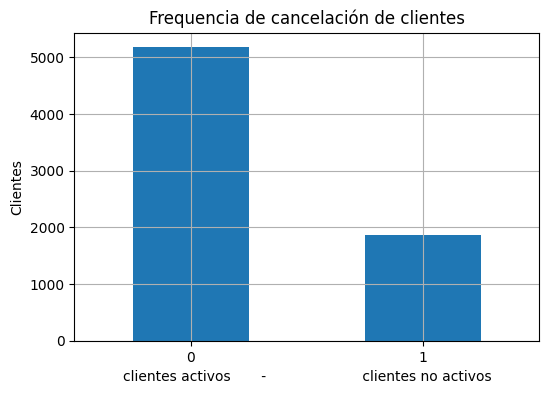

In [130]:
#Si se ha creado un gráfico antes de llamar a figsize, no tendrá efecto en el gráfico existente, es importante llamar a figsize antes 
#de crear el gráfico para asegurarte de que el tamaño se aplique correctamente.

count_contract = pd.Series(contract['enddate']).value_counts(sort = True)
plt.figure(figsize=(6, 4))
count_contract.plot(kind = 'bar', rot=0)
plt.title("Frequencia de cancelación de clientes")
plt.xlabel("clientes activos       -                      clientes no activos")
plt.ylabel("Clientes")
plt.grid();

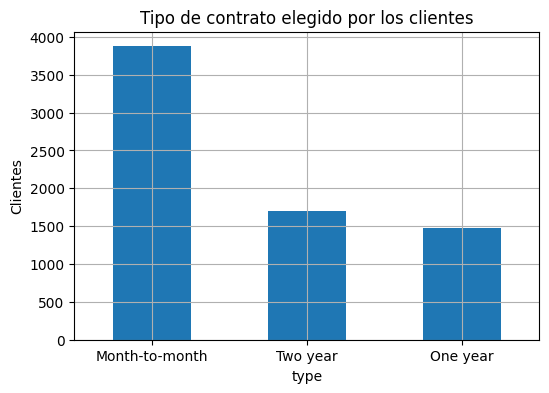

In [131]:
type_contract = pd.Series(contract['type']).value_counts(sort = True)
plt.figure(figsize=(6, 4))
type_contract.plot(kind = 'bar', rot=0)
plt.title("Tipo de contrato elegido por los clientes")
plt.ylabel("Clientes")
plt.grid();

- De acuerdo a los gráficos se puede observar que la mayoría de los clientes aún se encuentran activos, con poco más de 5000 clientes, mientras que los clientes que han cancelado su contrato equivalen a poco menos de 2000 clientes, asimismo la mayoría de ellos se inclina por el contrato mensual con casi 4000 contratos, seguido por el plan a dos años con casi 2000 y finalmente el plan anual con poco más de 1500 contratos.

### Internet
-Corregir tipos datos

In [132]:
#pasar nommbres de columnas a minúsculas
internet.columns = internet.columns.str.lower()
internet.columns

Index(['customerid', 'internetservice', 'onlinesecurity', 'onlinebackup',
       'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies'],
      dtype='object')

In [133]:
internet['onlinesecurity'] = np.where(internet['onlinesecurity'] == 'No', 0, 1)
internet['onlinebackup'] = np.where(internet['onlinebackup'] == 'No', 0, 1)
internet['deviceprotection'] = np.where(internet['deviceprotection'] == 'No', 0, 1)
internet['techsupport'] = np.where(internet['techsupport'] == 'No', 0, 1)
internet['streamingtv'] = np.where(internet['streamingtv'] == 'No', 0, 1)
internet['streamingmovies'] = np.where(internet['streamingmovies'] == 'No', 0, 1)

In [134]:
internet.head(3)

,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
0,7590-VHVEG,DSL,0,1,0,0,0,0
1,5575-GNVDE,DSL,1,0,1,0,0,0
2,3668-QPYBK,DSL,1,1,0,0,0,0


### -EDA-Internet-

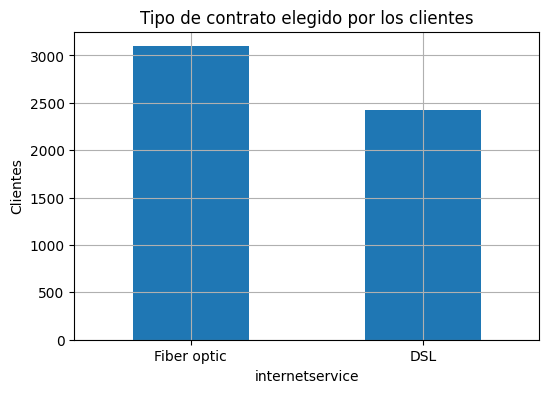

In [135]:
internet_contract = pd.Series(internet['internetservice']).value_counts(sort = True)
plt.figure(figsize=(6, 4))
internet_contract.plot(kind = 'bar', rot=0)
plt.title("Tipo de contrato elegido por los clientes")
plt.ylabel("Clientes")
plt.grid();

In [136]:
# Función para graficar datos internet

def graficar_col (df, columna, titulo, etiquetas, rotacion=0, tamano=(6, 4)):
    count_columna = pd.Series(df[columna]).value_counts(sort=True)
    
    plt.figure(figsize=tamano)
    count_columna.plot(kind='bar', rot=rotacion)
    
    plt.title(titulo)
    plt.xlabel(f"{etiquetas[0]} - {etiquetas[1]}")
    plt.ylabel("Clientes")
    plt.grid()
    plt.show()

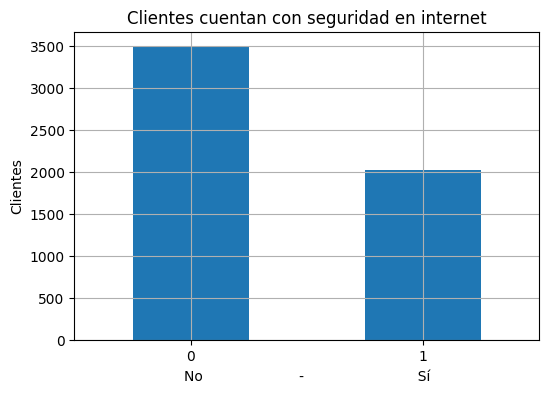

In [137]:
graficar_col (internet, 'onlinesecurity', 
                    "Clientes cuentan con seguridad en internet", 
                    ["No                     ", "                         Sí"])

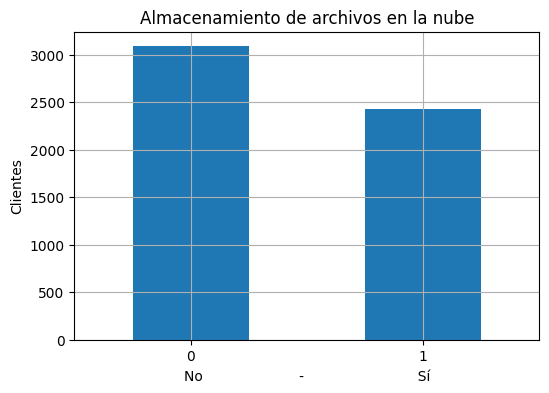

In [138]:
graficar_col(internet, 'onlinebackup', 
                    "Almacenamiento de archivos en la nube", 
                    ["No                     ", "                         Sí"])

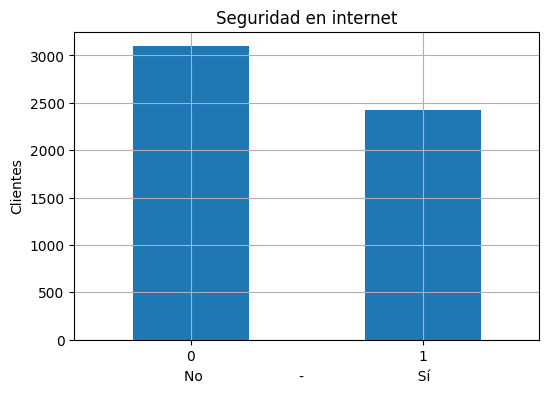

In [139]:
graficar_col(internet, 'deviceprotection', 
                    "Seguridad en internet", 
                    ["No                     ", "                         Sí"])

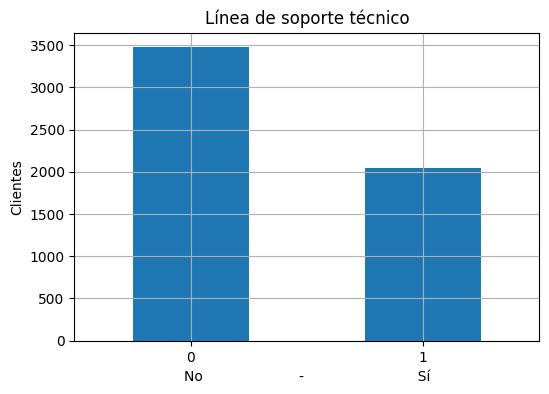

In [140]:
graficar_col(internet, 'techsupport', 
                    "Línea de soporte técnico", 
                    ["No                     ", "                         Sí"])

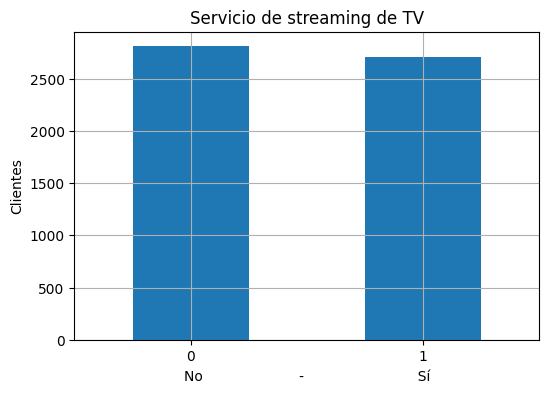

In [141]:
graficar_col(internet, 'streamingtv', 
                    "Servicio de streaming de TV", 
                    ["No                     ", "                         Sí"])

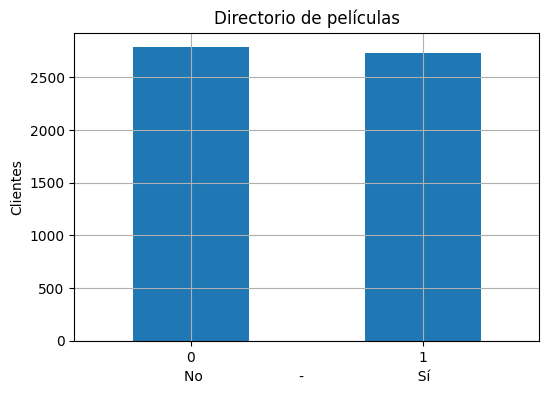

In [142]:
graficar_col(internet, 'streamingmovies', 
                    "Directorio de películas", 
                    ["No                     ", "                         Sí"])

De acuerdo a los gráficos acerca de los servicios del internet:

- La mayoría de clientes se inclina por los sevicios de internet DSL-línea de abonado digital con más de 3000 clientes a difrencia del servicio a través de un cable de fibra óptica que cuenta con menos de 2500 clientes.

- La mayoría de clientes opta por no protegerse, con el bloqueador de sitios web maliciosos con al rededor de 3500 miembros no asegurados, por otro lado poco más de 2000 clientes si hacen uso de este servicio.

- Al rededor de 3000 clientes optan por no almacenar sus archivos en la nube, ni tener un backup de sus datos mientras que casi 2500 clientes si han decidido hacer uso de este servicio.

- Un total de poco más de 3000 clientes no hacen uso del software antivirus y al rededor de un aproximado de 2400 si lo hacen.

- Aproximadamente un total de casi 3500 clientes no utilizan la línea de soporte, mientras que poco más de 2000 clientes si lo hacen.

- Más de 2500 clientes han contratado el servicio de streaming TV, por otro lado, igualmente más de 2500 clientes optaron por no contratar este servicio.

- Más de 2500 clientes han contratado el catálogo de peliculas de la empresa, por otro lado, igualmente más de 2500 clientes optaron por no contratar este servicio.

### Phone
-Corregir tipos datos

In [143]:
#pasar nommbres de columnas a minúsculas
phone.columns = phone.columns.str.lower()
phone.columns

Index(['customerid', 'multiplelines'], dtype='object')

In [144]:
phone['multiplelines'] = np.where(phone['multiplelines'] == 'No', 0, 1)
phone.sample(3)

,customerid,multiplelines
1501,7426-WEIJX,1
1700,7105-MXJLL,0
3812,4395-PZMSN,0


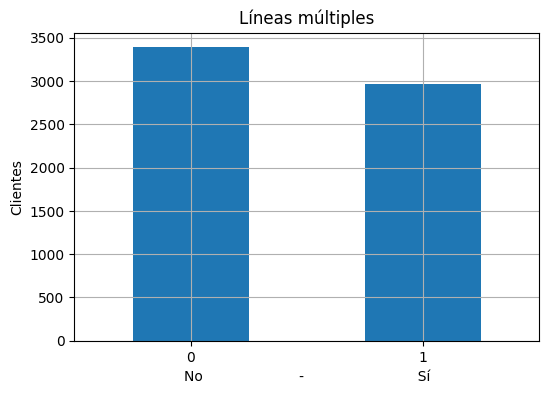

In [145]:
graficar_col(phone, 'multiplelines', 
                    "Líneas múltiples", 
                    ["No                     ", "                         Sí"])

- Alrededor de 3000 cientes cuentan con el servicio 'Multiple lines', que les permite conectarse a varias líneas de manera simultánea, mientras que casi 3500 clientes optan por rechazar este servicio.

### Personal
-Corregir tipos datos

In [146]:
#pasar nommbres de columnas a minúsculas
personal.columns = personal.columns.str.lower()
personal.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents'], dtype='object')

In [147]:
personal['partner'] = np.where(personal['partner'] == 'No', 0, 1)
personal['dependents'] = np.where(personal['dependents'] == 'No', 0, 1)
personal.sample(3)

,customerid,gender,seniorcitizen,partner,dependents
212,7157-SMCFK,Male,0,0,1
5960,2957-JIRMN,Female,1,0,0
4199,4088-YLDSU,Male,0,1,0


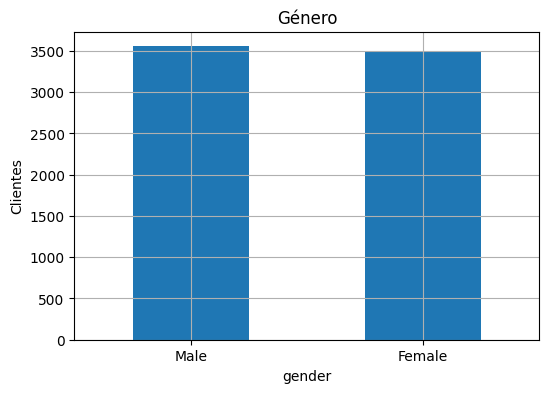

In [148]:
count_contract = pd.Series(personal['gender']).value_counts(sort = True)
plt.figure(figsize=(6, 4))
count_contract.plot(kind = 'bar', rot=0)
plt.title("Género")
plt.ylabel("Clientes")
plt.grid()
plt.show()

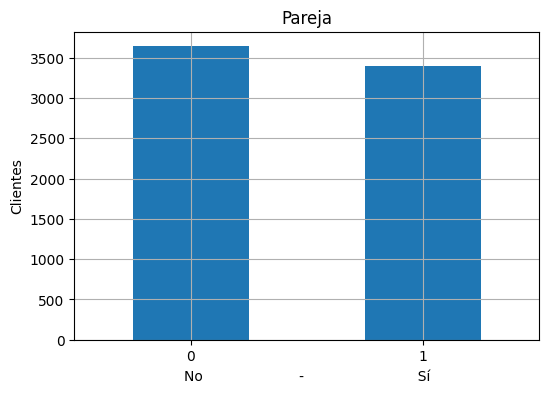

In [149]:
graficar_col(personal, 'partner', 
                    "Pareja", 
                    ["No                     ", "                         Sí"])

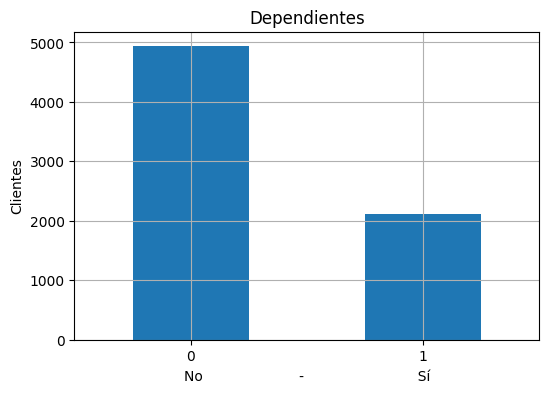

In [150]:
graficar_col(personal, 'dependents', 
                    "Dependientes", 
                    ["No                     ", "                         Sí"])

- Los datos para la columna 'género' sobrepasa los 3500 tanto para el género femenino como el masculino.

- Los datos acerca de si los clientes cuentan o no con pareja sobrepasa en ambos casos los 3000 clientes.

- De acuerdo al gráfico de 'dependientes', aproximandamente 5000 no cuenta con ellos, mientras que poco más de 2000 si.

### 2.1 Agrupar dataframes y creación de df con toda la información de los clientes

In [151]:
from functools import reduce
dataframes = [contract, internet, phone, personal]
data = reduce(lambda left, right: pd.merge(left, right, on='customerid', how='inner'), dataframes)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        4835 non-null   object        
 1   begindate         4835 non-null   datetime64[ns]
 2   enddate           4835 non-null   int32         
 3   type              4835 non-null   object        
 4   monthlycharges    4835 non-null   float64       
 5   totalcharges      4835 non-null   float64       
 6   internetservice   4835 non-null   object        
 7   onlinesecurity    4835 non-null   int32         
 8   onlinebackup      4835 non-null   int32         
 9   deviceprotection  4835 non-null   int32         
 10  techsupport       4835 non-null   int32         
 11  streamingtv       4835 non-null   int32         
 12  streamingmovies   4835 non-null   int32         
 13  multiplelines     4835 non-null   int32         
 14  gender            4835 n

In [152]:
data.head()

,customerid,begindate,enddate,type,monthlycharges,totalcharges,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,gender,seniorcitizen,partner,dependents
0,5575-GNVDE,2017-04-01,0,One year,56.95,1889.50,DSL,1,0,1,0,0,0,0,Male,0,0,0
1,3668-QPYBK,2019-10-01,1,Month-to-month,53.85,108.15,DSL,1,1,0,0,0,0,0,Male,0,0,0
2,9237-HQITU,2019-09-01,1,Month-to-month,70.70,151.65,Fiber optic,0,0,0,0,0,0,0,Female,0,0,0
3,9305-CDSKC,2019-03-01,1,Month-to-month,99.65,820.50,Fiber optic,0,0,1,0,1,1,1,Female,0,0,0
4,1452-KIOVK,2018-04-01,0,Month-to-month,89.10,1949.40,Fiber optic,0,1,0,0,1,0,1,Male,0,0,1


La column 'customerid' no afecta a la variable objetivo/ no afecta si un cliente se dará de baja o no por lo que se descartó del modelo.

In [153]:
data = data.drop(columns=['customerid'])
data.sample()

,begindate,enddate,type,monthlycharges,totalcharges,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,gender,seniorcitizen,partner,dependents
1129,2014-02-01,0,Two year,104.1,7447.7,Fiber optic,1,0,1,1,1,1,0,Male,1,1,1


### 2.2 One-Hot Encoding

Se usarán para tranformar características categóricas no ordinales, en este caso para 'gender' y 'country'

In [154]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output= False).set_output(transform='pandas')

In [155]:
ohetransform = ohe.fit_transform(data[['type', 'internetservice', 'multiplelines', 'gender']])

In [156]:
ohetransform = pd.DataFrame(ohetransform)
ohetransform.head(3)

,type_Month-to-month,type_One year,type_Two year,internetservice_DSL,internetservice_Fiber optic,multiplelines_0,multiplelines_1,gender_Female,gender_Male
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [157]:
data = pd.concat([data, ohetransform], axis=1).drop(columns=['type', 'internetservice', 'multiplelines', 'gender'])
data.head(3)

,begindate,enddate,monthlycharges,totalcharges,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,...,dependents,type_Month-to-month,type_One year,type_Two year,internetservice_DSL,internetservice_Fiber optic,multiplelines_0,multiplelines_1,gender_Female,gender_Male
0,2017-04-01,0,56.95,1889.50,1,0,1,0,0,0,...,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,2019-10-01,1,53.85,108.15,1,1,0,0,0,0,...,0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,2019-09-01,1,70.70,151.65,0,0,0,0,0,0,...,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [158]:
#Agrupar datos por año para el modelo
data['year']=data['begindate'].dt.month
data = data.drop(['begindate'], axis=1)

In [159]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   enddate                      4835 non-null   int32  
 1   monthlycharges               4835 non-null   float64
 2   totalcharges                 4835 non-null   float64
 3   onlinesecurity               4835 non-null   int32  
 4   onlinebackup                 4835 non-null   int32  
 5   deviceprotection             4835 non-null   int32  
 6   techsupport                  4835 non-null   int32  
 7   streamingtv                  4835 non-null   int32  
 8   streamingmovies              4835 non-null   int32  
 9   seniorcitizen                4835 non-null   int64  
 10  partner                      4835 non-null   int32  
 11  dependents                   4835 non-null   int32  
 12  type_Month-to-month          4835 non-null   float64
 13  type_One year     

## 3 Datos de entrenamiento y prueba

- Variable objetivo: enddate.
- Entrenamiento 60%, Prueba 20% y Validación 20%.

In [160]:
features = data.drop(['enddate'], axis=1)
target = data['enddate']

In [161]:
# entrenamiento y prueba
features_train,features_valid,target_train,target_valid = train_test_split(features,target, random_state= 12345, test_size=0.25)
print('Tamaño del set de entrenamiento:', features_train.shape, target_train.shape)
print('Tamaño del set de prueba:', features_valid.shape, target_valid.shape)

Tamaño del set de entrenamiento: (3626, 21) (3626,)
Tamaño del set de prueba: (1209, 21) (1209,)


### 3.1 SMOTE para el balanceo de clases

Desbalanceo de clases -> Clasificación mayoritaria: modelos tienden a clasificar todo como la clase mayoritaria.

- SMOTE (síntesis de la minoría) para el balanceo de clases: Técnica estadística para aumentar el número de casos en su conjunto de datos de forma equilibrada, encontrando los vecinos más cercanos y carga datos "medios". Funciona creando instancias sintéticas de la clase minoritaria mediante la interpolación de instancias existentes.

In [162]:
target.value_counts()

enddate
0    3249
1    1586
Name: count, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

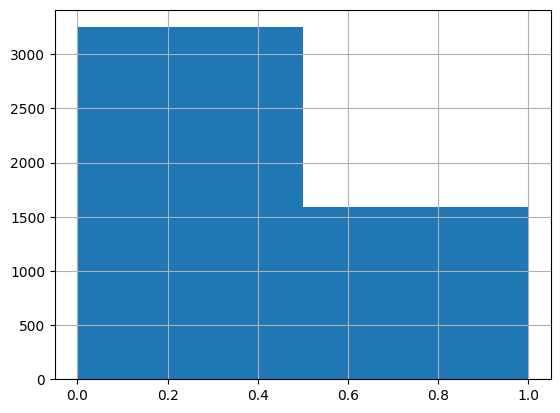

In [163]:
plt.hist(target, bins=2)
plt.grid()
plt.show

- Más de 3000 clientes aún reciben los servicios de Interconnect.
- Poco más de 1500 clientes han cancelado los servicios de Interconnect.

In [164]:
smote = SMOTE(random_state=42, k_neighbors=15)

In [165]:
features_train_smote, target_train_smote = smote.fit_resample(features_train, target_train)

## 4 Modelado

#### - AUC-ROC

Una puntuación ligeramente superior a 0,5 muestra que un modelo tiene al menos "algo" (aunque pequeño) poder predictivo (generalmente es inadecuado para aplicaciones reales).

Una puntuación AUC superior a 0,8 se considera buena, mientras que una puntuación superior a 0,9 se considera excelente.

#### - F1 Score

El F1 score es una métrica de evaluación en aprendizaje automático que mide la exactitud/presición de un modelo de clasificación.

Accuracy no, ya que por la forma en la que este se calcula va beneficiar la clase mayoritaria y lo que se busca en este caso es predecir mejor la clase minoritaria para entender cuando un usuario dejará el servicio, es mejor el f1-score para esta tarea.

### =====Regresión logística=====

In [166]:
rl = LogisticRegression(random_state=54321, solver='liblinear')

In [167]:
rl.fit(features_train, target_train)

LogisticRegression(random_state=54321, solver='liblinear')

In [168]:
valid_rl = rl.predict(features_valid)

In [169]:
f1_score_rl = sklearn.metrics.f1_score(target_valid, valid_rl, average='macro')
print('El valor de f1 score para el modelo de regresión logística es de:')
print(f1_score_rl)

El valor de f1 score para el modelo de regresión logística es de:
0.7234835550687756


In [170]:
roc_rl = roc_auc_score(target_valid, valid_rl)
print('El valor de roc-auc para el modelo de regresion logística es de:')
print(roc_rl)
#regresion linear

El valor de roc-auc para el modelo de regresion logística es de:
0.7163408445111736


- SMOTE DATA

In [171]:
rl.fit(features_train_smote, target_train_smote)

LogisticRegression(random_state=54321, solver='liblinear')

In [172]:
valid_rl_smote = rl.predict(features_valid)

In [173]:
f1_score_rl_smote = sklearn.metrics.f1_score(target_valid, valid_rl_smote, average='macro')
print('El valor de f1 score para el modelo de regresión logística aplicando el método de balanceo SMOTE es de:')
print(f1_score_rl_smote)

El valor de f1 score para el modelo de regresión logística aplicando el método de balanceo SMOTE es de:
0.7306256124414572


In [174]:
roc_rl_smote = roc_auc_score(target_valid, valid_rl_smote)
print('El valor de roc-auc para el modelo de regresion logística aplicando el método de balanceo SMOTE es de:')
print(roc_rl)
#regresion linear

El valor de roc-auc para el modelo de regresion logística aplicando el método de balanceo SMOTE es de:
0.7163408445111736


### =====Árbol de desición=====

In [175]:
dt = DecisionTreeClassifier(max_depth=15)
# Se utilizó classifier y no regressor por la variable objetivo que queremos predecir, en este caso categórica
# max_depth para evitar el sobreajuste 
# max_depth en valores de regresión suele ser de 5-15, es recomendable empezar con un valor pequeño y aumentar gradualmente hasta encontrar el valor óptimo
# en este caso el valor óptimo de max_depth fue 

In [176]:
dt.fit(features_train, target_train)

DecisionTreeClassifier(max_depth=15)

In [177]:
valid_dt = dt.predict(features_valid)

In [178]:
f1_score_dt = sklearn.metrics.f1_score(target_valid, valid_dt, average='macro')
print('El valor de f1 score para el modelo de árbol de desición es de:')
print(f1_score_dt)

El valor de f1 score para el modelo de árbol de desición es de:
0.7801358214917538


In [179]:
roc_dt = roc_auc_score(target_valid, valid_dt)
print('El valor de roc-auc para el modelo de Árbol de desición es de:')
print(roc_dt)

El valor de roc-auc para el modelo de Árbol de desición es de:
0.7858895534240796


In [180]:
dt.fit(features_train_smote, target_train_smote)

DecisionTreeClassifier(max_depth=15)

In [181]:
valid_dt_smote = dt.predict(features_valid)

In [182]:
f1_score_dt_smote = sklearn.metrics.f1_score(target_valid, valid_dt_smote, average='macro')
print('El valor de f1 score para el modelo de árbol de desición aplicando el método de balanceo SMOTE es de:')
print(f1_score_dt_smote)

El valor de f1 score para el modelo de árbol de desición aplicando el método de balanceo SMOTE es de:
0.7495251604473775


In [183]:
roc_dt_smote = roc_auc_score(target_valid, valid_dt_smote)
print('El valor de roc-auc para el modelo de Árbol de desición aplicando el método de balanceo SMOTE es de:')
print(roc_dt_smote)

El valor de roc-auc para el modelo de Árbol de desición aplicando el método de balanceo SMOTE es de:
0.7566136417217803


### =====Bosque aleatorio=====

In [184]:
rf = RandomForestClassifier(n_estimators=100, max_depth=100)
# Se utilizó classifier y no regressor por la variable objetivo que queremos predecir, en este caso una categórica

In [185]:
rf.fit(features_train, target_train)

RandomForestClassifier(max_depth=100)

In [186]:
valid_rf = rf.predict(features_valid)

In [187]:
f1_score_rf = sklearn.metrics.f1_score(target_valid, valid_rf, average='macro')
print('El valor de f1 score para el modelo de bosque aleatorio es de:')
print(f1_score_rf)

El valor de f1 score para el modelo de bosque aleatorio es de:
0.7555479938454255


In [188]:
roc_rf = roc_auc_score(target_valid, valid_rf)
print('El valor de roc-auc para el modelo de random forest es de:')
print(roc_rf)

El valor de roc-auc para el modelo de random forest es de:
0.743601953071683


- SMOTE

In [189]:
rf.fit(features_train_smote, target_train_smote)

RandomForestClassifier(max_depth=100)

In [190]:
valid_rf_smote = rf.predict(features_valid)

In [191]:
f1_score_rf_smote = sklearn.metrics.f1_score(target_valid, valid_rf_smote, average='macro')
print('El valor de f1 score para el modelo de bosque aleatorio aplicando el método de balanceo SMOTE es de:')
print(f1_score_rf_smote)

El valor de f1 score para el modelo de bosque aleatorio aplicando el método de balanceo SMOTE es de:
0.7628434673013649


In [192]:
roc_rf_smote = roc_auc_score(target_valid, valid_rf_smote)
print('El valor de roc-auc para el modelo de random forest aplicando el método de balanceo SMOTE es de:')
print(roc_rf_smote)

El valor de roc-auc para el modelo de random forest aplicando el método de balanceo SMOTE es de:
0.7571472000595599


### =====LightGBMClassifier=====

In [193]:
clf = LGBMClassifier(learning_rate=0.1, max_depth=13, n_estimators=150, num_leaves=50)
# tasa de aprendizaje de ese valor para no aumentar riesgo de sobreajuste
# n_estimator, es el no de arboles de secidión que se usará en el modelo
# num_leaves: hojas en cada arbol

In [194]:
clf.fit(features_train, target_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1189, number of negative: 2437
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 559
[LightGBM] [Info] Number of data points in the train set: 3626, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.327910 -> initscore=-0.717655
[LightGBM] [Info] Start training from score -0.717655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

c:\Users\aleve\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LGBMClassifier(max_depth=13, n_estimators=150, num_leaves=50)

In [195]:
valid_clf = clf.predict(features_valid)

In [196]:
f1_score_clf = sklearn.metrics.f1_score(target_valid, valid_clf, average='macro')
print('El valor de f1 score para el modelo de LGBMClassifier es de:')
print(f1_score_clf)

El valor de f1 score para el modelo de LGBMClassifier es de:
0.8104924870927108


In [197]:
roc_clf = roc_auc_score(target_valid, valid_clf)
print('El valor de roc-auc para el modelo de LGBMC es de:')
print(roc_clf)

El valor de roc-auc para el modelo de LGBMC es de:
0.7981226191510219


- SMOTE

In [198]:
clf.fit(features_train_smote, target_train_smote)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2437, number of negative: 2437
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1812
[LightGBM] [Info] Number of data points in the train set: 4874, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\aleve\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LGBMClassifier(max_depth=13, n_estimators=150, num_leaves=50)

In [199]:
valid_clf_smote = clf.predict(features_valid)

In [200]:
f1_score_clf_smote = sklearn.metrics.f1_score(target_valid, valid_clf_smote, average='macro')
print('El valor de f1 score para el modelo de LGBMClassifier aplicando el método de balanceo SMOTE es de:')
print(f1_score_clf_smote)

El valor de f1 score para el modelo de LGBMClassifier aplicando el método de balanceo SMOTE es de:
0.8031696793391896


In [201]:
roc_clf_smote = roc_auc_score(target_valid, valid_clf_smote)
print('El valor de roc-auc para el modelo de LGBMC aplicando el método de balanceo SMOTE es de:')
print(roc_clf_smote)

El valor de roc-auc para el modelo de LGBMC aplicando el método de balanceo SMOTE es de:
0.7965265972627216


### =====CatBoostClassifer=====

In [202]:
catbc = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=5, verbose=False)

In [203]:
catbc.fit(features_train,target_train)

In [204]:
valid_catbc = catbc.predict(features_valid)

In [205]:
f1_score_catbc = sklearn.metrics.f1_score(target_valid, valid_catbc, average='macro')
print('El valor de f1-score para el modelo de CATBC es de:')
print(f1_score_catbc)

El valor de f1-score para el modelo de CATBC es de:
0.7901798229804958


In [206]:
roc_catbc = roc_auc_score(target_valid, valid_catbc)
print('El valor de roc-auc para el modelo de CATBC es de:')
print(roc_catbc)

El valor de roc-auc para el modelo de CATBC es de:
0.7734377908203149


- SMOTE

In [207]:
catbc.fit(features_train_smote, target_train_smote)

In [208]:
valid_catbc_smote = catbc.predict(features_valid)

In [209]:
f1_score_catbc_smote = sklearn.metrics.f1_score(target_valid, valid_catbc_smote, average='macro')
print('El valor de f1-score para el modelo de CATBC aplicando el método de balanceo SMOTE es de:')
print(f1_score_catbc_smote)

El valor de f1-score para el modelo de CATBC aplicando el método de balanceo SMOTE es de:
0.7876020056091215


In [210]:
roc_catbc_smote = roc_auc_score(target_valid, valid_catbc_smote)
print('El valor de roc-auc para el modelo de CATBC aplicando el método de balanceo SMOTE es de:')
print(roc_catbc)

El valor de roc-auc para el modelo de CATBC aplicando el método de balanceo SMOTE es de:
0.7734377908203149


## 6 Resultados

In [211]:
res_dicc = {
    'Modelo': ['Regresión Lineal', 'Árbol de Decisión','Bósque Aleatorio', 'LGBMClassifier', 'CatBoostClassifier',],
    'AUC_ROC': [roc_rl, roc_dt, roc_rf, roc_clf, roc_catbc],
    'F1_Score': [f1_score_rl, f1_score_dt, f1_score_rf, f1_score_clf, f1_score_catbc]
}

res_df = pd.DataFrame(res_dicc)

print(res_df)  

               Modelo   AUC_ROC  F1_Score
0    Regresión Lineal  0.716341  0.723484
1   Árbol de Decisión  0.785890  0.780136
2    Bósque Aleatorio  0.743602  0.755548
3      LGBMClassifier  0.798123  0.810492
4  CatBoostClassifier  0.773438  0.790180


In [212]:
res_dicc_smote = {
    'Modelo': ['Regresión Lineal', 'Árbol de Decisión','Bósque Aleatorio', 'LGBMClassifier', 'CatBoostClassifier',],
    'AUC_ROC': [roc_rl_smote, roc_dt_smote, roc_rf_smote, roc_clf_smote, roc_catbc_smote],
    'F1_Score': [f1_score_rl_smote, f1_score_dt_smote, f1_score_rf_smote, f1_score_clf_smote, f1_score_catbc_smote]
}

res_df_smote = pd.DataFrame(res_dicc_smote)

print('Modelos con datos equilibrados con SMOTE')
print()
print(res_df_smote) 

Modelos con datos equilibrados con SMOTE

               Modelo   AUC_ROC  F1_Score
0    Regresión Lineal  0.741863  0.730626
1   Árbol de Decisión  0.756614  0.749525
2    Bósque Aleatorio  0.757147  0.762843
3      LGBMClassifier  0.796527  0.803170
4  CatBoostClassifier  0.782197  0.787602


## 5 Conclusiones

- Se utilizaron todos los conjuntos de datos proporcionados por la empresa, los cuales se trabajaron como Dataframes.

- Se eliminaron algunas columnas de los DataFrames ya que no eran relevantes para el procesamiento y modelado de datos; asimismo se realizo una limpieza de los mismos en donde se corrigieron algunos tipos de datos y se prepararon para trabajarlos posteriormente durante el modelado.

- Se realizó un análisis exploratorio de datos en el que se analizó la distribución de la información relevante para el proyecto.

- Se realizo la técnica de balanceo de clases SMOTE.

- Se generaron cinco modelos, 'Regresión Lineal', 'Árbol Decisión','Bósque Aleatorio', 'LGBMClassifier' y 'CatBoostClassifier', los cuales fueron entrenados con datos balanceados y no balanceados.

- Los modelos fueron evaluados mediante las métricas AUC-ROC y f1-score para conocer el rendimiento de los modelos de clasificación.

- Se obtuvó un mayor número de modelos con mejores resultados utilizando datos balanceados, sin embargo, el mejor modelo o bien, el que presentó las métricas más altas se obtuvo con los datos sin balancear.

- LightGBM Classifier, Árbol de Desición y CatBoostClassifier presentronn los mejores resultados.

- **El modelo LightGBM Classifier presentó los mejores resultados con un AUC-ROC de 0.798123 y f1-score de 0.810492.**